# Transformer Decoder on GRU Encoder

This notebook replaces the decoder with the full Transformer stack while keeping the encoder as a GRU, positioning the model one step away from the complete Transformer architecture.


In [1]:
import math
import os
import torch
from torch import nn
from d2l import torch as d2l


import importlib
import hw7
importlib.reload(hw7)
from hw7 import *










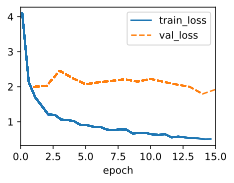

In [2]:
from tsv_seq2seq_data import TSVSeq2SeqData
# data_path = os.path.expanduser('~/Dropbox/CS6140/data/sentence_pairs_large.tsv')
# data = TSVSeq2SeqData(
#     path=data_path,
#     batch_size=512,
#     num_steps=25,
#     min_freq=2,
#     val_frac=0.05,
#     test_frac=0.0,
#     sample_percent=1,
# )

data = d2l.MTFraEng(batch_size=128)

embed_size = 256
num_hiddens = 320 
num_blks = 3 
dropout = 0.35 
ffn_num_hiddens = 1280 

num_layers = 3
num_heads = 8

#encoder = BatchFirstGRUEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
encoder = SelfAttentionAugmentedEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers,
                                         num_heads=num_heads, dropout=dropout)

decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens,
                             ffn_num_hiddens, num_heads,
                             num_blks, dropout)

model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.0005)
trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [ ]:
# examples = ['necesito ayuda urgente .', 'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .', 'cuando llegara el proximo tren a madrid ?']
# references = ['i need urgent help .', 'it rained a lot in the city yesterday .', 'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

# preds, _ = model.predict_step(
#     data.build(examples, references), d2l.try_gpu(), data.num_steps)
# for src, tgt, pred in zip(examples, references, preds):
#     translation = []
#     for token in data.tgt_vocab.to_tokens(pred):
#         if token == '<eos>':
#             break
#         translation.append(token)
#     print(f"{src} => {' '.join(translation)} | reference: {tgt}")


examples = ['vamos .', 'me perdi .', 'esta tranquilo .', 'estoy en casa .', 'donde esta el tren ?',    'necesito ayuda urgente .',
    'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .',
    'cuando llegara el proximo tren a madrid ?']

references = ['go .', 'i got lost .', 'he is calm .', 'i am at home .', 'where is the train ?',
    'i need urgent help .', 'it rained a lot in the city yesterday .',
    'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

preds, _ = model.predict_step(
    data.build(examples, references), d2l.try_gpu(), data.num_steps)
for src, tgt, pred in zip(examples, references, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(pred):
        if token == '<eos>':
            break
        translation.append(token)
    
    hypo = ' '.join(translation)
    print(f"{src} => {hypo}    |  reference: {tgt}  | BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")


vamos . => let's go together.    |  reference: go .  | BLEU: 0.000
me perdi . => i was disappointed with me.    |  reference: i got lost .  | BLEU: 0.000
esta tranquilo . => this sentence is broken.    |  reference: he is calm .  | BLEU: 0.000
estoy en casa . => i'm at home right now.    |  reference: i am at home .  | BLEU: 0.447
donde esta el tren ? => where the train will be repaired    |  reference: where is the train ?  | BLEU: 0.473
necesito ayuda urgente . => i need help help help help help you help me any more.    |  reference: i need urgent help .  | BLEU: 0.275
ayer llovio mucho en la ciudad . => yesterday we spent a lot of snow in the city yesterday.    |  reference: it rained a lot in the city yesterday .  | BLEU: 0.547
los ninos estan jugando en el parque . => the <unk> <unk> playing in the park in the park during the park.    |  reference: the children are playing in the park .  | BLEU: 0.439
ella quiere aprender a hablar ingles muy bien . => she wants to learn to learn t

In [7]:




examples = ['vamos .', 'me perdi .', 'esta tranquilo .', 'estoy en casa .', 'donde esta el tren ?',    'necesito ayuda urgente .',
    'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .',
    'cuando llegara el proximo tren a madrid ?']

references = ['go .', 'i got lost .', 'he is calm .', 'i am at home .', 'where is the train ?',
    'i need urgent help .', 'it rained a lot in the city yesterday .',
    'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

for src, tgt in zip(examples, references):
    src_sentence = src.lower().split()
    src_tokens = [data.src_vocab[token] for token in src_sentence]
    pred_ids = beam_search_translate(model, src_tokens, data, beam_size=5, max_steps=40)
    translation = data.tgt_vocab.to_tokens(pred_ids)
    hypo = ' '.join(translation)
    print(f"{src} => {hypo}    |  reference: {tgt}  | BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")


vamos . => we're we're we're we're we're we're we're on we're we're we're we're we're we're we're we're we're we're we're we're we're we're on our we're on our we're on our we're on our we're on our we're on our we're    |  reference: go .  | BLEU: 0.000
me perdi . => i was taking my <unk> to kill me. i moved to kill me. i moved to kill me. i moved to me. i moved to me. i moved to me. i moved to me. i moved to me. myself. <eos>    |  reference: i got lost .  | BLEU: 0.000
esta tranquilo . => this christmas holiday this movie this christmas holiday this movie this movie this evening, this movie this movie this movie. let's read this movie. let's read this movie. let's this movie. this movie. this movie. this movie. this movie. this    |  reference: he is calm .  | BLEU: 0.000
estoy en casa . => i'm at home right now, i'm at home right now. i'm at home right now. i'm at home right now. i'm at home right now. i'm at home. i'm at home right now. i'm at home tomorrow. i'm at home.    |  ref

In [3]:
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]  # Evaluation prompts
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']  # Ground-truth translations
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)  # Batch translation on GPU
for en, fr, p in zip(engs, fras, preds):
    translation = []  # Accumulate predicted tokens until EOS
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break  # Stop once decoder predicts sequence end
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f"{d2l.bleu(' '.join(translation), fr, k=2):.3f}")  # Report BLEU per sentence


go . => ['va', '<unk>', '!'], bleu,0.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['il', 'est', '<unk>', '.'], bleu,0.658
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512
